# ONLINE PAYMENT FRAUD DETECTION 

### IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

#### LOADING THE DATA

In [2]:
file_path = "C:/Users/Hp/Documents/ML/credit_fraud_data.csv"

In [3]:
dataframe = pd.read_csv(file_path)

In [4]:
dataframe.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### UNDERSTANDING THE DATASET

The dataset consists of 10 numerical and 1 non-numerical column. The columns consists of features gotten from customer's online transaction. The features will be explained in points below:
- step : represents a unit of time where 1 step represents an hour.
- type : online transaction type
- amount : transaction amount
- nameOrig : customer starting the transaction
- oldbalanceOrg : balance before the transaction
- newbalanceOrg : balance after the transaction
- nameDest : recipient of the transaction
- oldbalanceDest : initial balance of recipient before the transaction
- newbalanceDest : the new balance of recipient after the transaction
- isFraud : this checks if the transaction is fraudlent or not. Where 1 is fraud and 0 is not fraud.

### DATA PREPROCESSING AND FEATURE SELECTION

In [5]:
dataframe.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


#### CHECKING FOR MISSING VALUES

In [6]:
dataframe.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### CHECKING FOR UNIQUE VALUES IN THE NON-NUMERICAL COLUMN AND ENCODING IT

In [7]:
dataframe["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

#### LABEL ENCODER

In [8]:
encoder = LabelEncoder()

In [9]:
dataframe["type"] = encoder.fit_transform(dataframe["type"])

In [10]:
# new encoded dataframe
dataframe.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### FEATURE EXTRACTION

In any good training pipeline, Festure selection is a critical component in deciding which features will be used as inputs to the model. For many models, a small subset of input variables provide the lion share of predictive ability. It is important to lower the amount of input variables for some reasons such as:
- reducing multi collineariry
- reducing model training time and compute resources
- easy understanding of important points
- reduce dimenionality problems

Some features in a dataset has little to no input to the predictability and generalizability of a model. In our dataset, we can clearly see that the features which plays little to no effect in the model prediction are:
- step, as the timing or time unit has little effect in fraud detection
- nameOrig, as the customer name and ID has no effect
- nameDest, also the receiver ID has no effect

Hence these columns will be dropped from our dataset. In bigger datasets where the features are overly technical, there are statistical features which help in feature extraction such as Chi square and SelectKbest.

#### DROPPING COLUMNS

In [11]:
dataframe.drop(["step", "nameOrig", "nameDest"], axis=1, inplace=True)

#### EXPLORATORY DATA VISUALIZATION

array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'oldbalanceOrg'}>],
       [<Axes: title={'center': 'newbalanceOrig'}>,
        <Axes: title={'center': 'oldbalanceDest'}>,
        <Axes: title={'center': 'newbalanceDest'}>],
       [<Axes: title={'center': 'isFraud'}>,
        <Axes: title={'center': 'isFlaggedFraud'}>, <Axes: >]],
      dtype=object)

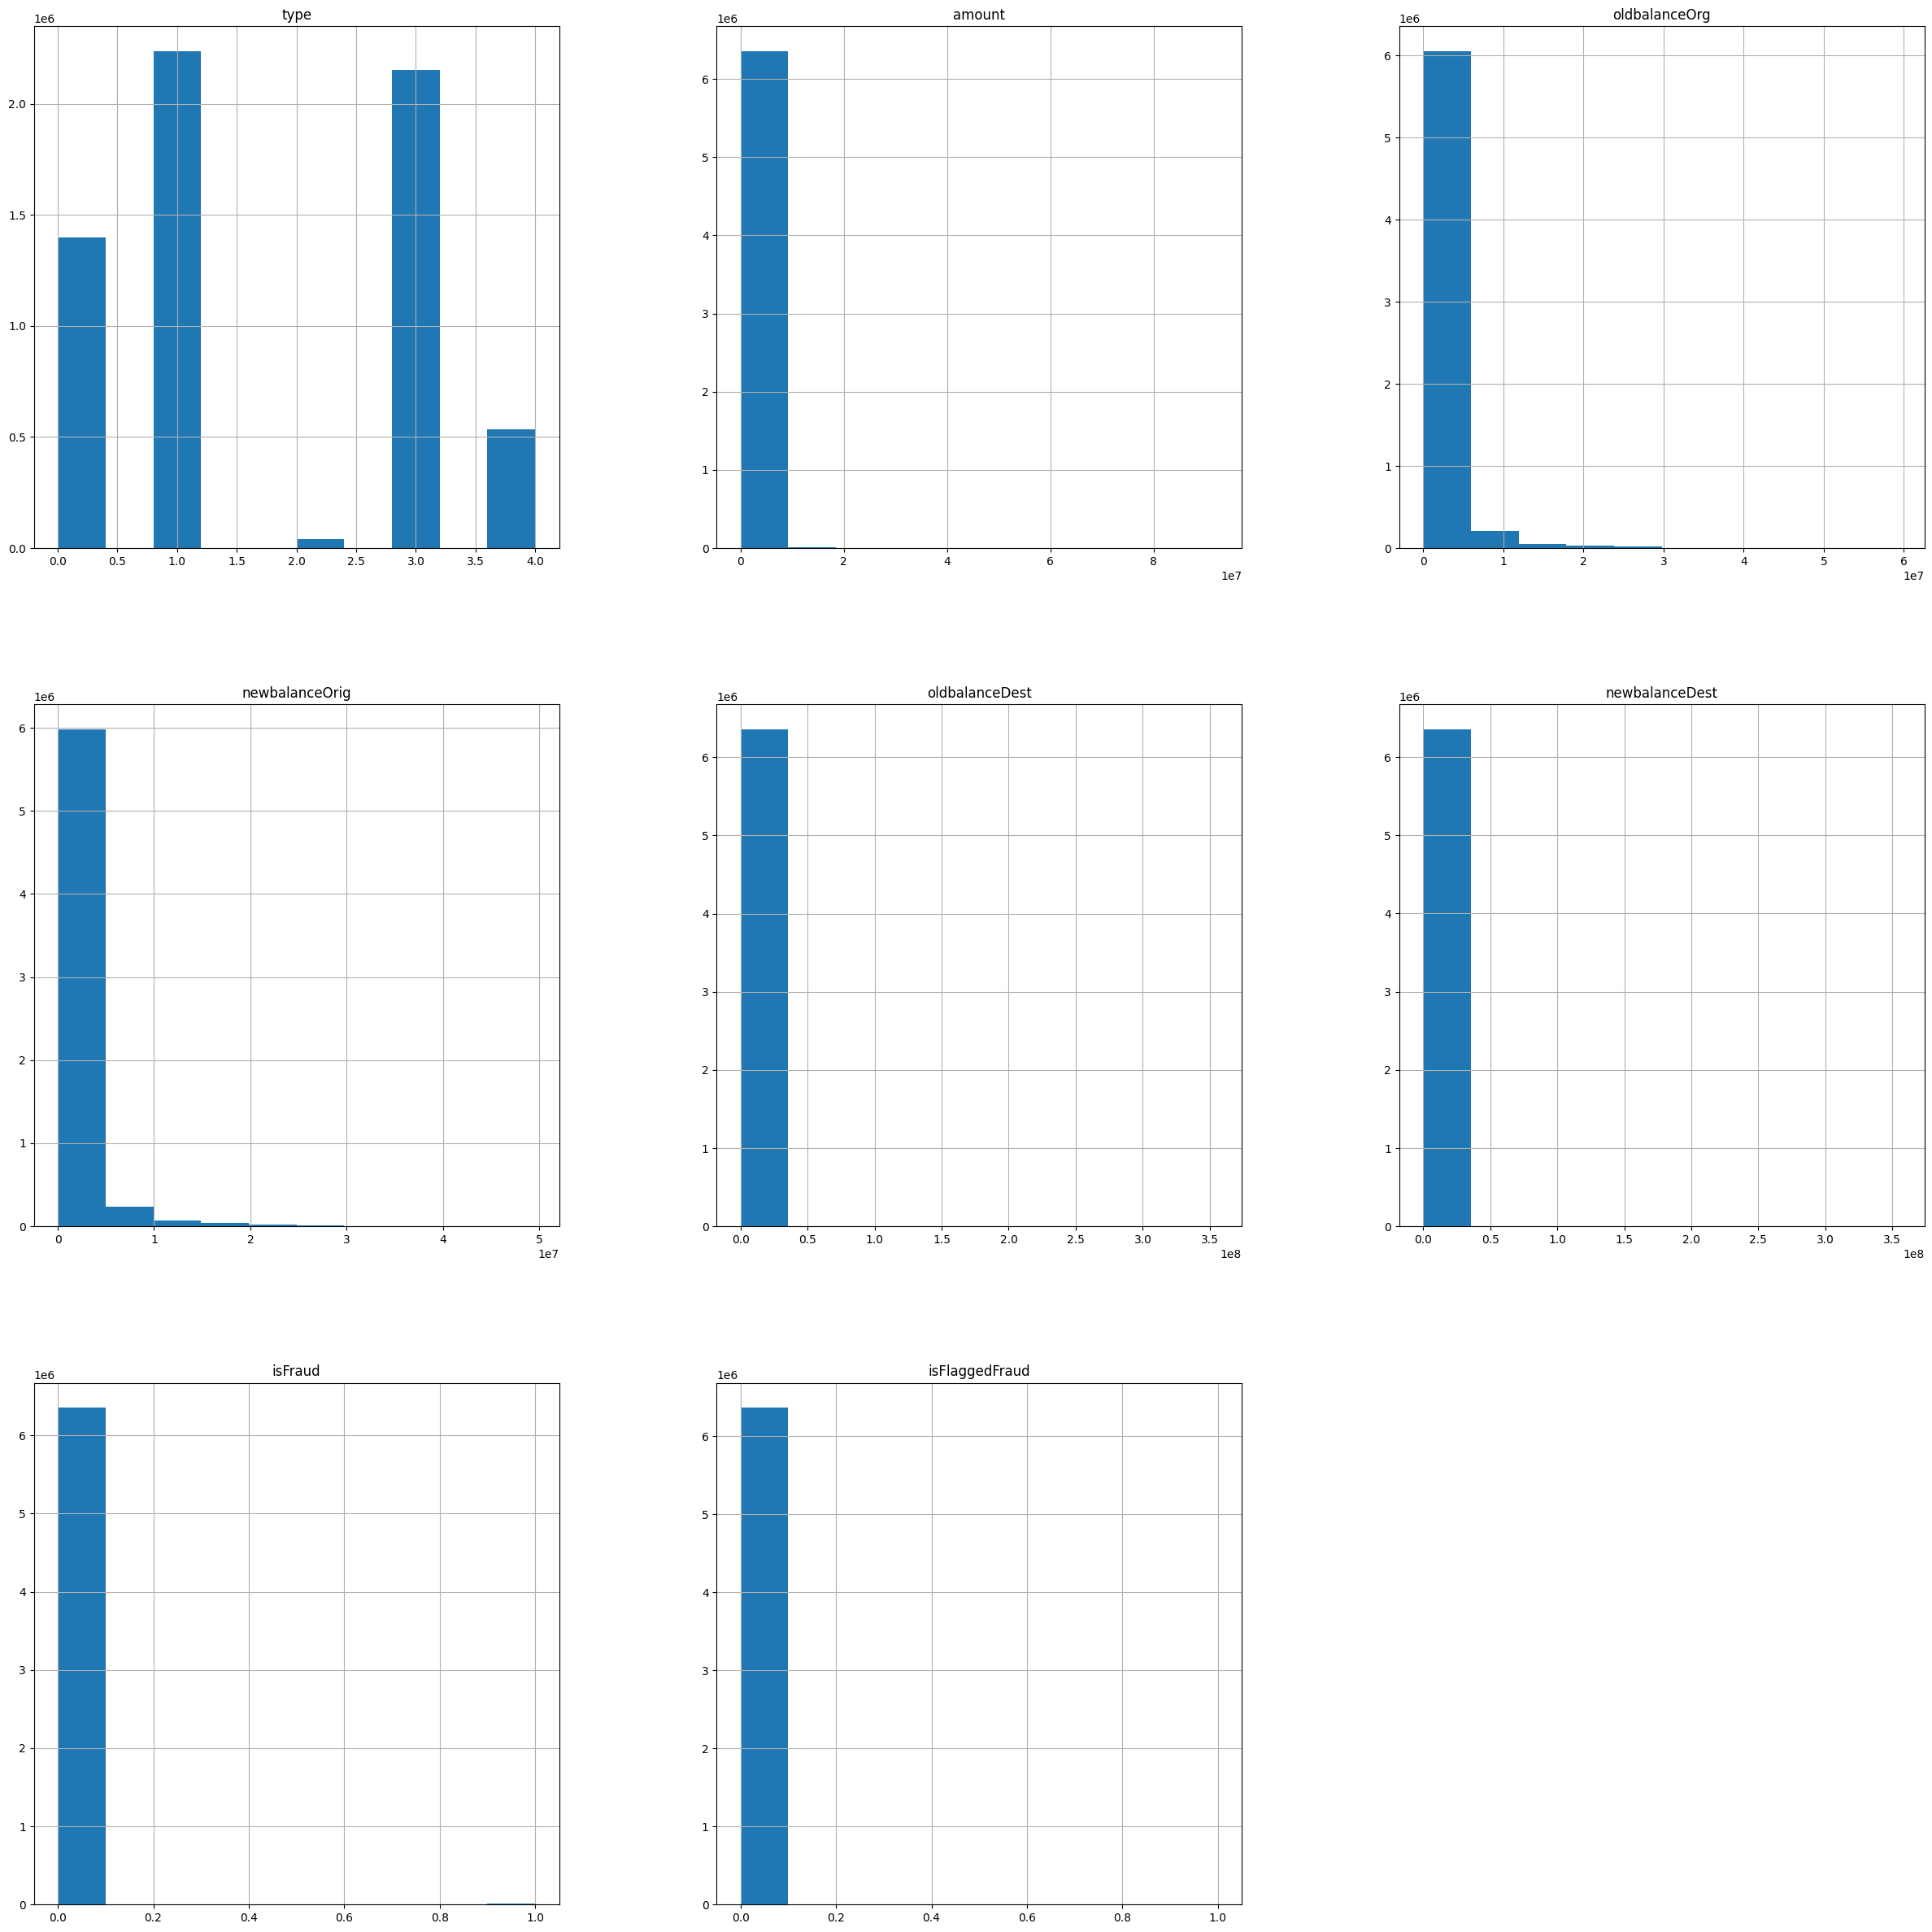

In [12]:
dataframe.hist(figsize = (30,30))

#### VISUALIZING THE LABELS

In [13]:
label_counts = dataframe["isFraud"].value_counts()

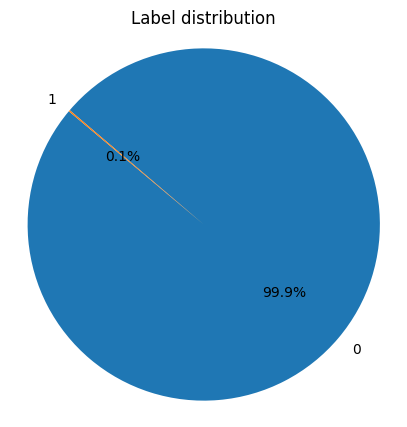

In [14]:
plt.figure(figsize=(5,5))
plt.pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Label distribution")
plt.axis("equal")
plt.show()

In [15]:
# dataframe inofo
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            int32  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
 7   isFlaggedFraud  int64  
dtypes: float64(5), int32(1), int64(2)
memory usage: 364.1 MB


#### OUTLIER DETECTION

Outliers are datapoints that deviates from the other points in a dataset. They lie far away from the central tendency of the distribution. When dealing with tree based models like decision trees and neural networks, the effect of outliers can be overlooked because the tree based models and neural networks are robust to outliers meaning they handle outliers with little to no effect on the output result of the model after training.

In [16]:
column = "isFraud"

In [17]:
Q1 = dataframe[column].quantile(0.25)
Q3 = dataframe[column].quantile(0.75)

In [18]:
inter_quantile_range = Q3 - Q1

In [19]:
# define boundaries
upper = Q1 - 1.5 * inter_quantile_range
lower = Q3 + 1.5 * inter_quantile_range

In [20]:
# outliers
outliers = dataframe[(dataframe[column] < lower) | (dataframe[column] > upper)]

In [21]:
outliers

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,4,181.00,181.00,0.0,0.00,0.00,1,0
3,1,181.00,181.00,0.0,21182.00,0.00,1,0
251,4,2806.00,2806.00,0.0,0.00,0.00,1,0
252,1,2806.00,2806.00,0.0,26202.00,0.00,1,0
680,4,20128.00,20128.00,0.0,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...
6362615,1,339682.13,339682.13,0.0,0.00,339682.13,1,0
6362616,4,6311409.28,6311409.28,0.0,0.00,0.00,1,0
6362617,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0
6362618,4,850002.52,850002.52,0.0,0.00,0.00,1,0


#### VISUALIZING THE OUTLIERS

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'type'),
  Text(1, 0, 'amount'),
  Text(2, 0, 'oldbalanceOrg'),
  Text(3, 0, 'newbalanceOrig'),
  Text(4, 0, 'oldbalanceDest'),
  Text(5, 0, 'newbalanceDest'),
  Text(6, 0, 'isFraud'),
  Text(7, 0, 'isFlaggedFraud')])

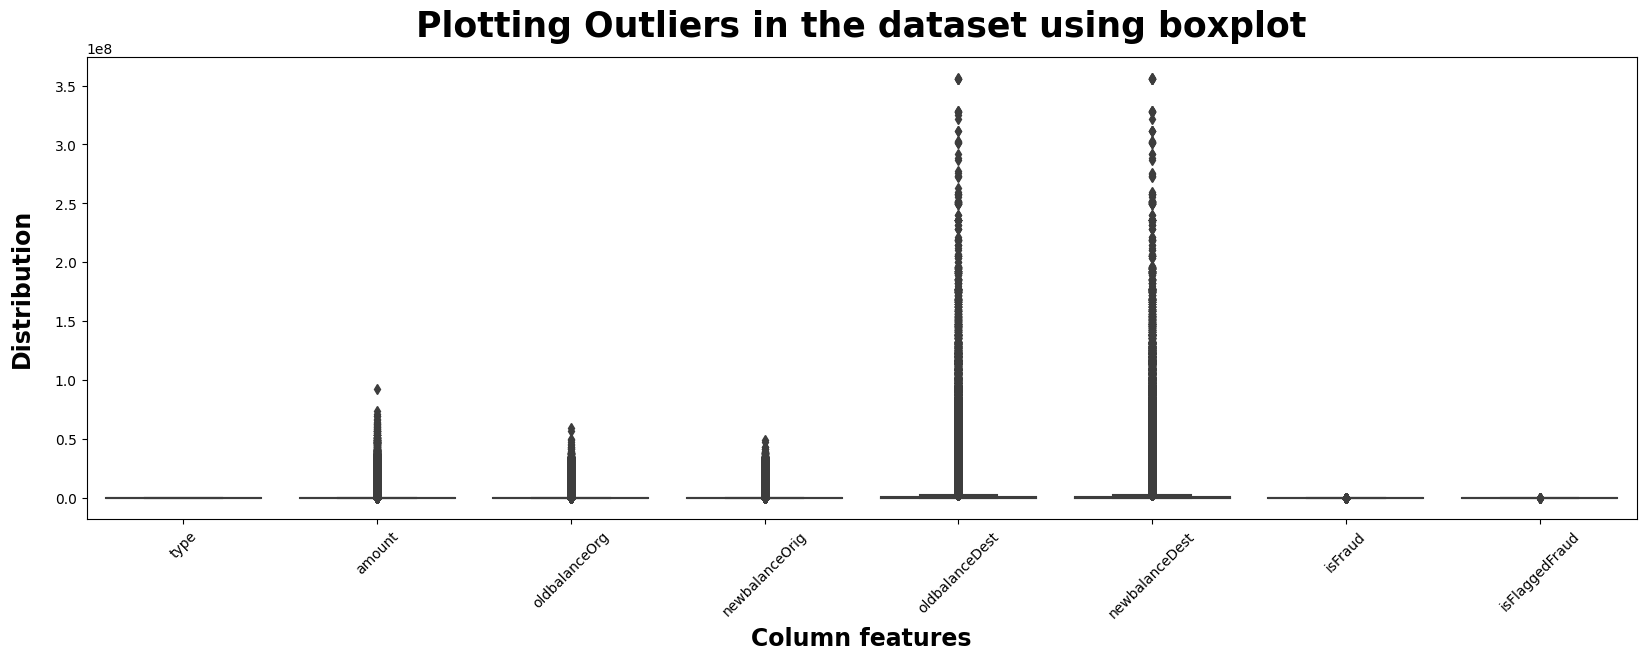

In [22]:
plt.figure(figsize = (20, 6))
sns.boxplot(data = dataframe)

plt.title('Plotting Outliers in the dataset using boxplot', weight = "bold", fontsize = 25, pad = 15)
plt.xlabel('Column features', weight = "bold", fontsize = 17)
plt.ylabel('Distribution', labelpad = 15, weight = "bold", fontsize = 17)

plt.xticks(rotation = 45)

#### CORRELATION MATRIX

In [23]:
correlation = dataframe.corr()

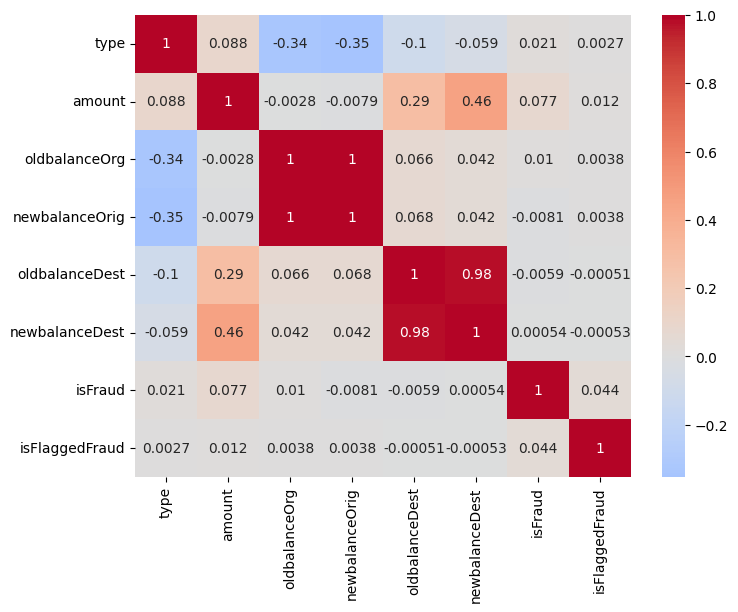

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap = "coolwarm", center = 0)
plt.show()

#### INITIALIZATIONS

In [25]:
# the random seed aids repetition and production of deterministic results 
# initialization of default training unit to CPU if GPU is not available
RANDOM_SEED = 46
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 100

### CREATING A CUSTOM DATASET CLASS

In [26]:
class Fraud_Dataset(Dataset):
    def __init__(self, df, column=None, transform=None):
        self.df = df
        self.X = df.drop(column, axis=1).values.astype(np.float32)  # Convert DataFrame to NumPy array
        self.y = df[column].values.astype(np.float32)  # Convert Series to NumPy array
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            # Apply the transform on the entire dataset, not a single data point
            self.X = self.transform.fit_transform(self.X)
            self.y = self.transform.fit_transform(self.y.reshape(-1, 1)).flatten()

        X = torch.from_numpy(X).float()
 
        return X, y

#### DEFINING TRANSFORM

In [27]:
transform = StandardScaler()

In [28]:
dataset = Fraud_Dataset(df=dataframe, column="isFraud", transform=transform)

In [29]:
len(dataset)

6362620

## DATA SPLITTING AND NORMALIZATION

In machine learning, data can be inputed in several magnitudes and sometimes it may hinder the model from learning some important data points or features correctly, with such a problem, the need to normalize or standardize our data becomes of utmost importance. Normalization is a technique used to transform the features of a dataset into a common scale, that is to represent the datapoints magnitude within a common range so that the machine learning is not influenced by the disproportional datapoints helping the data to converge faster and perform better.

#### SPLITTIING THE DATASET USING RANDOM SPLIT FOR THE DATASET INSTANCE

In [30]:
# initialize the train size to 70% of the dataset while the 30% goes for testing and validation
train_size = int(0.7 * len(dataset))
test_val_size = len(dataset) - train_size

In [31]:
# implementing the 70-30% split using random split
train_dataset, test_val_dataset = random_split(dataset, [train_size, test_val_size])

In [32]:
# split (test_val_set) to get the percentage size for test and validation dataset
test_size = test_val_size // 2
val_size = test_val_size - test_size

In [33]:
# implementing the test-val size on the remaining 30% of the dataset to get the test dataset and validation dataset using random split
test_dataset, val_dataset = random_split(test_val_dataset, [test_size, val_size])

#### CREATING RANDOM SAMPLE FOR DATALOADER SUBSETS

#### train dataloader

In [34]:
subset_size_t = int(0.1 * len(train_dataset))

In [35]:
train_subset, _ = torch.utils.data.random_split(train_dataset, [subset_size_t, len(train_dataset) - subset_size_t])

#### validation dataloader

In [36]:
subset_size_v = int(0.1 * len(val_dataset))

In [37]:
val_subset, _ = torch.utils.data.random_split(val_dataset, [subset_size_v, len(val_dataset) - subset_size_v])

#### test dataloader

In [38]:
subset_size_t = int(0.3 * len(test_dataset))

In [39]:
test_subset, _ = torch.utils.data.random_split(test_dataset, [subset_size_t, len(test_dataset) - subset_size_t])

#### DATALOADER IMPLEMENTATION

In [40]:
# pytorch dataloader implementation for the train dataloader
train_dataloader = DataLoader(train_subset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True,
                              )

In [41]:
# pytorch dataloader implementation for the validation dataloader
val_dataloader = DataLoader(val_subset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            )

In [42]:
# pytorch dataloader implementation for the test dataloader
test_dataloader = DataLoader(test_subset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False,
                             )

In [43]:
# checking the shape
first_batch = next(iter(train_dataloader))

In [ ]:
# checking the dimension of the dataloader
for batch_idx, (inputs, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Input shape: {inputs.shape}, Labels shape: {labels.shape}")
    break

### CREATING A MULTILAYER PERCEPTRON USING PYTORCH

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiLayerPerceptron, self). __init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.5)
        self.layer4 = nn.Linear(128, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = torch.relu(self.layer4(x))
        return x

#### INSTANTIATE A MODEL

In [ ]:
# when performing binary classification, a single output neuron with a sigmoid activation function is used to produce a score between o and 1
model = MultiLayerPerceptron(input_dim = inputs.shape[1], output_dim = 1)

In [ ]:
model.to(device)

#### UTILS

In [ ]:
NUM_EPOCHS = 5
batch_size = BATCH_SIZE
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### TRAINING LOOP

In [ ]:
# The training loop is a pytorch convention, here the train and validation loaders are trained and tested using early stoppings
#Storing the loss and accuracy value for each epoch
train_losses = []
accuracy_values = []

#validation itemization
r_val_correct = 0
r_val_total = 0
r_val_losses = []
r_accuracy_val_values = []

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        
    #initializing the prediction count to zero before the loop
    total = 0
    correct = 0
        
    for batch_idx, (inputs, labels) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        #get data to cuda if possible
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #handling the dimension of the target[32], since the input is [32,1]
        labels = labels.unsqueeze(1)
        
        #forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        #This code accumulates training loss, stores loss values for each batch
        train_loss += loss.item()
        train_losses.append(loss.item())
        
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        #back propagation
        loss.backward()
        
        # gradient descent
        optimizer.step()
        optimizer.zero_grad()
        
    epoch_loss = train_loss / num_batches
    print('Epoch {} loss: {:.3f}'.format(epoch + 1, epoch_loss))
    train_accuracy = 100 * (correct / total)
    accuracy_values.append(train_accuracy)
    
    # validation accuracy
    model.eval()
    
    with torch.no_grad():
        val_loss = 0.0
        
        for batch_idx, (inputs, labels) in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # get loss
            val_loss += loss.item()
            val_losses.append(loss.item())
            
            # get prediction
            _, predicted = torch.max(outputs, dim=1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        
        # Calculate the average validation loss after the loop
        val_loss /= len(val_dataloader)
        
        # Check improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            current_patience = 0
        else:
            current_patience += 1
   
        # Print accuracy and check for early stopping
        val_accuracy = 100 * (val_correct / val_total)
        # store accuracy values
        accuracy_val_values.append(val_accuracy)
        # store validation loss outside the loop
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # If early stopping criteria met
        if current_patience >= patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break

#### TESTING

In [ ]:
test_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # get loss
        test_loss += loss.item()
        #test_losses.append(test_loss)
        test_losses.append(loss.item())

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        total_samples += labels.size(0)

        # calculate accuracy
        correct_pred += (predicted == labels).sum()

        # get predicted and actual labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_dataloader.dataset)
accuracy = correct_pred / total_samples

# view loss and accuracy
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(test_loss, accuracy))

#### CHECKING OTHER EVALUATION METRICS FOR MULTILAYER PERCEPTRON

In [ ]:
# these are gotten from the sklearn library
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average = "weighted")
recall = recall_score(all_labels, all_predictions, average = "weighted")
f1 = f1_score(all_labels, all_predictions, average = "weighted")

#### MLP RESULTS

In [ ]:
print(f"Accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}")

#### MLP CLASSIFICATION REPORT

In [ ]:
report = classification_report(all_labels, all_predictions)
print(report)

#### RESULT VISUALIZATIONS

#### CONFUSION MATRIX

In [ ]:
c_matrix = confusion_matrix(all_labels, all_predictions)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="Blues", fmt=".2%", cbar=True)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

In [ ]:
# plot loss progress
plt.title("Training Loss trends for CNN model")
plt.plot(c_train_losses, label = "Training loss")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# plot accuracy progress
plt.title("Training Accuracy trends for CNN model")
plt.plot(c_accuracy_values, label = "Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

#### ROC CURVE

In [ ]:
fp, tp, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)
plt.figure()
plt.plot(fp, tp, color="blue", lw=2, label="roc curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("roc curve")
plt.legend()
plt.show()